Crea una classe di backtesting per la strategia di regressione logistica. La classe accetta i soliti parametri (strumento, start, end), il parametro **lags** e il parametro **train_ratio** tra 0.5 e 1 che è quanta parte dei dati va utilizzata per il training, mentre il resto va utilizzata per il test. Ad esempio con train_ratio=0.9 l'ultimo 10% dei dati viene utilizzato per il test mentre il primo 90% viene utilizzato per l'addestramento dei parametri.

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
plt.style.use("seaborn")
from sklearn.linear_model import LogisticRegression
from itertools import product

In [2]:
import tpqoa
api = tpqoa.tpqoa("oanda.cfg")

In [43]:
class LogisticRegressionBacktester():
    def __init__(self, symbol, lags, trainratio, start, end):
        self._symbol = symbol
        self._lags=lags
        self._trainratio=trainratio
        self._start=start
        self._end=end
        self.results=None #none eh variabile vuota
        self._train=None
        self._test=None
        self._model=None
        self._columns=[]
        self.get_data()
        self.prepare_data()
        
      
    def get_data(self):
        df=api.get_history(instrument=self._symbol, start=self._start, end=self._end, granularity="D", price="B").c.to_frame()
        df["logret"]=np.log(df.c/df.c.shift(1))
        df["direction"]=np.sign(df.logret)
        self._data=df.dropna()
        
    def prepare_data(self):
        for lag in range(1,self._lags+1):
            col="logret"+str(lag)
            self._data[col]=self._data.logret.shift(lag)
            self._columns.append(col)
        self._train=self._data.iloc[:math.floor(len(self._data)*self._trainratio)]
        self._test=self._data.iloc[math.floor(len(self._data)*self._trainratio):]
        
    
    def execute_train(self):
        logisticmodel=LogisticRegression(multi_class="ovr", C=1e6, max_iter=1e6)
        self._train.dropna(inplace=True)
        logisticmodel.fit(X=self._train[self._columns], y=self._train.direction)
        self._train["predicted"]=logisticmodel.predict(self._train[self._columns])
        self._model=logisticmodel
        return self._train
    
    def plot_trainresults(self):
            ((self._train.predicted*self._train.logret).cumsum()).plot(figsize=(25,15))
            titolo=self._symbol + " Predicted Gains on Train with Lags= " + str(self._lags) + ", and Trainratio " + str(self._trainratio)
            plt.title(titolo, fontsize=22)
            plt.show()
            
    def execute_test(self):
        self._test["predicted"]=(self._model.predict(self._test[self._columns])) 
        #self._test["predicted"]=np.sign(self._model.predict(self._test[self._columns])) #OKO here
        self._test["predicttransact"]= abs(self._test.predicted-self._test.predicted.shift(1))
        self._test.dropna(inplace=True)
        return self._test
            
    def plot_testresults(self):
        comm=0.0015
        spread=0.00008/self._test.c.mean() 
        (self._test.predicted*self._test.logret).cumsum().plot()
        ((self._test.predicted*self._test.logret)-(self._test.predicttransact*(comm+spread/2))).cumsum().plot()
        #plt.legend(fontsize=18)
        titolo=self._symbol + " Predicted Gains on Test with and W/o Commission with Lags= " + str(self._lags) + ", and Trainratio " + str(self._trainratio)
        plt.title(titolo, fontsize=22)
        plt.show()
        
    def attempt_optimize(self, lagsrange, ratiorange):
        bestperformances=[]
        bestcombinations=[]
        for t in range(ratiorange[0],ratiorange[1]+1,1):
            currtuples=[]
            currresults=[]
            self._lags=lagsrange
            self._trainratio=t/10
            self.execute_train()
            self.execute_test()
            for i in range(1,lagsrange[1]+1):
                currtuples.append((i,t))
                currresults.append(((self._test["logret"+str(i)])*(self._test.predicted)).sum())
            bestperf = np.max(currresults)
            bestcomb = currtuples[np.argmax(currresults)]
            bestperformances.append(bestperf)
            bestcombinations.append(bestcomb)
        bestperfFinal = np.max(bestperformances)
        bestcombFinal = bestcombinations[np.argmax(bestperformances)]
        #print(bestperformances)
        #print(bestcombinations)
        return bestperfFinal,bestcombFinal

In [44]:
LRObj = LogisticRegressionBacktester(symbol = "EUR_USD", lags=3, trainratio=0.9, start = "2008-10-10", end = "2021-10-10")

In [29]:
LRObj._data.head(30)

,c,logret,direction,logret1,logret2,logret3
time,,,,,,
2008-10-10 21:00:00,1.33923,-0.000403,-1.0,NaN,NaN,NaN
2008-10-11 21:00:00,1.35705,0.013218,1.0,-0.000403,NaN,NaN
2008-10-12 21:00:00,1.35818,0.000832,1.0,0.013218,-0.000403,NaN
2008-10-13 21:00:00,1.36174,0.002618,1.0,0.000832,0.013218,-0.000403
2008-10-14 21:00:00,1.34977,-0.008829,-1.0,0.002618,0.000832,0.013218
2008-10-15 21:00:00,1.34543,-0.003221,-1.0,-0.008829,0.002618,0.000832
2008-10-16 21:00:00,1.34033,-0.003798,-1.0,-0.003221,-0.008829,0.002618
2008-10-18 21:00:00,1.34210,0.001320,1.0,-0.003798,-0.003221,-0.008829
2008-10-19 21:00:00,1.33425,-0.005866,-1.0,0.001320,-0.003798,-0.003221


In [45]:
LRObj.execute_train()

C:\Users\Laura\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\Laura\AppData\Local\Temp/ipykernel_904/3123946787.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._train["predicted"]=logisticmodel.predict(self._train[self._columns])


,c,logret,direction,logret1,logret2,logret3,predicted
time,,,,,,,
2008-10-13 21:00:00,1.36174,0.002618,1.0,0.000832,0.013218,-0.000403,-1.0
2008-10-14 21:00:00,1.34977,-0.008829,-1.0,0.002618,0.000832,0.013218,-1.0
2008-10-15 21:00:00,1.34543,-0.003221,-1.0,-0.008829,0.002618,0.000832,1.0
2008-10-16 21:00:00,1.34033,-0.003798,-1.0,-0.003221,-0.008829,0.002618,1.0
2008-10-18 21:00:00,1.34210,0.001320,1.0,-0.003798,-0.003221,-0.008829,1.0
...,...,...,...,...,...,...,...
2020-04-21 21:00:00,1.08226,-0.002971,-1.0,-0.000663,-0.000635,0.002967,1.0
2020-04-22 21:00:00,1.07756,-0.004352,-1.0,-0.002971,-0.000663,-0.000635,1.0
2020-04-23 21:00:00,1.08182,0.003946,1.0,-0.004352,-0.002971,-0.000663,1.0


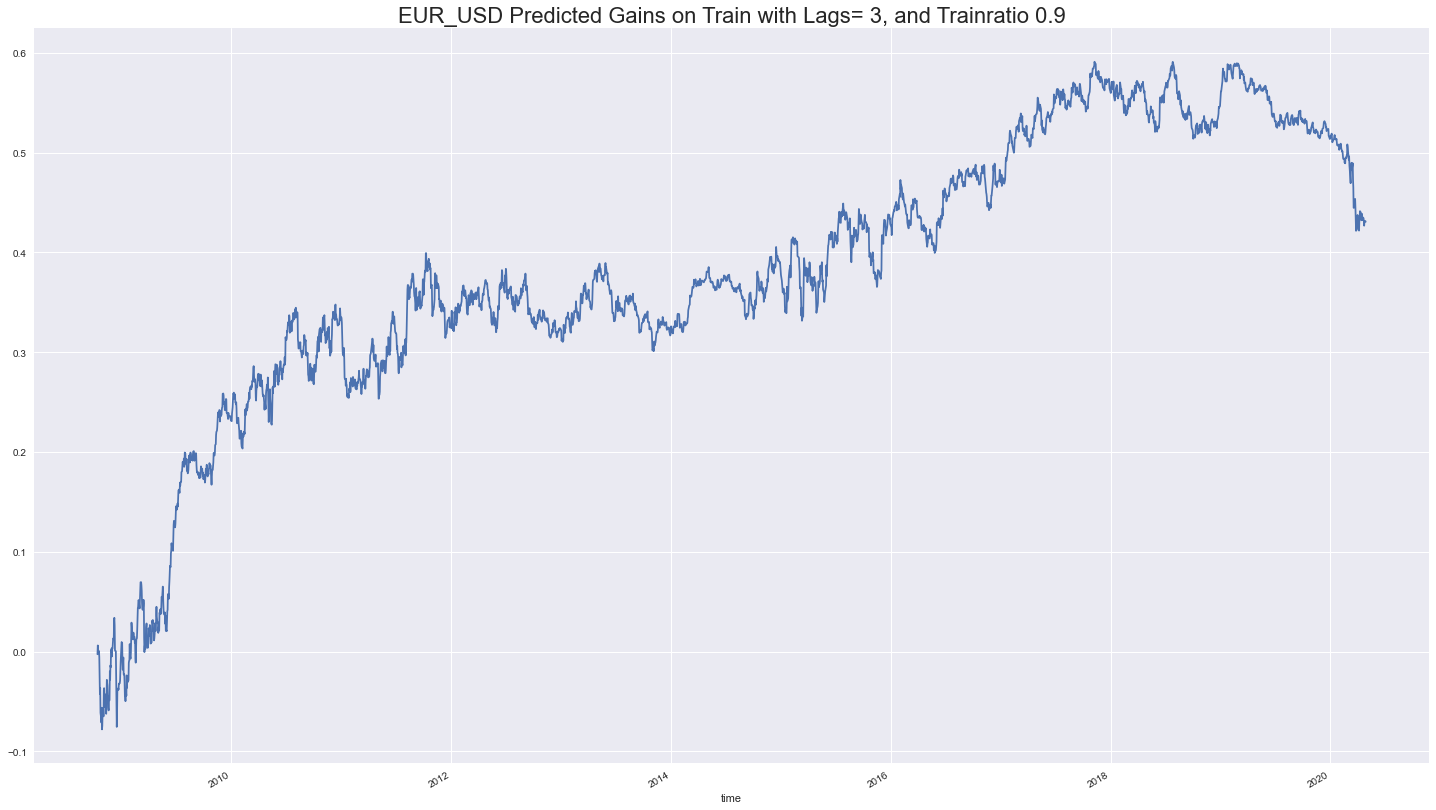

In [7]:
LRObj.plot_trainresults()

In [32]:
LRObj.execute_test()

C:\Users\Laura\AppData\Local\Temp/ipykernel_904/669576329.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._test["predicted"]=np.sign(self._model.predict(self._test[self._columns])) #OKO here
C:\Users\Laura\AppData\Local\Temp/ipykernel_904/669576329.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._test["predicttransact"]= abs(self._test.predicted-self._test.predicted.shift(1))
C:\Users\Laura\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is tr

,c,logret,direction,logret1,logret2,logret3,predicted,predicttransact
time,,,,,,,,
2020-04-29 21:00:00,1.09506,0.007314,1.0,0.004804,-0.000748,0.000795,-1.0,0.0
2020-04-30 21:00:00,1.09744,0.002171,1.0,0.007314,0.004804,-0.000748,-1.0,0.0
2020-05-03 21:00:00,1.09004,-0.006766,-1.0,0.002171,0.007314,0.004804,-1.0,0.0
2020-05-04 21:00:00,1.08358,-0.005944,-1.0,-0.006766,0.002171,0.007314,1.0,2.0
2020-05-05 21:00:00,1.07940,-0.003865,-1.0,-0.005944,-0.006766,0.002171,1.0,0.0
...,...,...,...,...,...,...,...,...
2021-10-03 21:00:00,1.16174,0.002206,1.0,0.001347,-0.001726,-0.007423,1.0,0.0
2021-10-04 21:00:00,1.15963,-0.001818,-1.0,0.002206,0.001347,-0.001726,1.0,0.0
2021-10-05 21:00:00,1.15548,-0.003585,-1.0,-0.001818,0.002206,0.001347,1.0,0.0


In [9]:
df1=LRObj._test
df1

,c,logret,direction,logret1,logret2,logret3,predicted,predicttransact
time,,,,,,,,
2020-04-29 21:00:00,1.09506,0.007314,1.0,0.004804,-0.000748,0.000795,-1.0,0.0
2020-04-30 21:00:00,1.09744,0.002171,1.0,0.007314,0.004804,-0.000748,-1.0,0.0
2020-05-03 21:00:00,1.09004,-0.006766,-1.0,0.002171,0.007314,0.004804,-1.0,0.0
2020-05-04 21:00:00,1.08358,-0.005944,-1.0,-0.006766,0.002171,0.007314,1.0,2.0
2020-05-05 21:00:00,1.07940,-0.003865,-1.0,-0.005944,-0.006766,0.002171,1.0,0.0
...,...,...,...,...,...,...,...,...
2021-10-03 21:00:00,1.16174,0.002206,1.0,0.001347,-0.001726,-0.007423,1.0,0.0
2021-10-04 21:00:00,1.15963,-0.001818,-1.0,0.002206,0.001347,-0.001726,1.0,0.0
2021-10-05 21:00:00,1.15548,-0.003585,-1.0,-0.001818,0.002206,0.001347,1.0,0.0


In [10]:
(df1.logret1*df1.predicted).sum()

-0.7770001233308146

In [11]:
(np.sign(LRObj._train.direction*LRObj._train.predicted)).value_counts()

 1.0    1696
-1.0    1607
 0.0      76
dtype: int64

In [12]:
(np.sign(LRObj._test.direction*LRObj._test.predicted)).value_counts()

-1.0    196
 1.0    179
dtype: int64

In [13]:
# commentario: per entrambi situazione di test e train, l'algoritmo prevede giusto e non giusto 
# praticamente al 50% ogni uno, cosa che non sembra così ottimale. 
# I rendimenti nello scopo dello testing possono sembrare prommissori, ma vengono distrutti dalle commissioni e spread.
# Come visto in lezione, il problema vero è la commissione. Facendo trading da un market maket, dove non c'è
# commissioni e c'è solo spread, potrebbe andare bene in questo caso come strategia. 

In [14]:
LRObj.attempt_optimize((1,3),(5,7))

C:\Users\Laura\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\Laura\AppData\Local\Temp/ipykernel_904/367067698.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._train["predicted"]=logisticmodel.predict(self._train[self._columns])
C:\Users\Laura\AppData\Local\Temp/ipykernel_904/367067698.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

(-0.28974283907106746, (2, 7))

In [15]:
# inseriamo i risultati di sopra nella classe 

In [16]:
LRObj2 = LogisticRegressionBacktester(symbol = "EUR_USD", lags=2, trainratio=0.7, start = "2008-10-10", end = "2021-10-10")

In [17]:
LRObj2.execute_train()

C:\Users\Laura\AppData\Local\Temp/ipykernel_904/367067698.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._train["predicted"]=logisticmodel.predict(self._train[self._columns])


,c,logret,direction,logret1,logret2,predicted
time,,,,,,
2008-10-12 21:00:00,1.35818,0.000832,1.0,0.013218,-0.000403,-1.0
2008-10-13 21:00:00,1.36174,0.002618,1.0,0.000832,0.013218,1.0
2008-10-14 21:00:00,1.34977,-0.008829,-1.0,0.002618,0.000832,-1.0
2008-10-15 21:00:00,1.34543,-0.003221,-1.0,-0.008829,0.002618,1.0
2008-10-16 21:00:00,1.34033,-0.003798,-1.0,-0.003221,-0.008829,1.0
...,...,...,...,...,...,...
2017-05-30 21:00:00,1.12422,0.005172,1.0,0.002032,-0.001325,-1.0
2017-05-31 21:00:00,1.12116,-0.002726,-1.0,0.005172,0.002032,-1.0
2017-06-01 21:00:00,1.12804,0.006118,1.0,-0.002726,0.005172,1.0


In [18]:
LRObj2.execute_test()

C:\Users\Laura\AppData\Local\Temp/ipykernel_904/367067698.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._test["predicted"]=np.sign(self._model.predict(self._test[self._columns]))
C:\Users\Laura\AppData\Local\Temp/ipykernel_904/367067698.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._test["predicttransact"]= abs(self._test.predicted-self._test.predicted.shift(1))
C:\Users\Laura\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be

,c,logret,direction,logret1,logret2,predicted,predicttransact
time,,,,,,,
2017-06-07 21:00:00,1.12118,-0.003819,-1.0,-0.001900,0.002024,1.0,2.0
2017-06-08 21:00:00,1.11933,-0.001651,-1.0,-0.003819,-0.001900,1.0,0.0
2017-06-11 21:00:00,1.12024,0.000813,1.0,-0.001651,-0.003819,1.0,0.0
2017-06-12 21:00:00,1.12096,0.000643,1.0,0.000813,-0.001651,1.0,0.0
2017-06-13 21:00:00,1.12171,0.000669,1.0,0.000643,0.000813,1.0,0.0
...,...,...,...,...,...,...,...
2021-10-03 21:00:00,1.16174,0.002206,1.0,0.001347,-0.001726,1.0,0.0
2021-10-04 21:00:00,1.15963,-0.001818,-1.0,0.002206,0.001347,-1.0,2.0
2021-10-05 21:00:00,1.15548,-0.003585,-1.0,-0.001818,0.002206,1.0,2.0


In [19]:
df2=LRObj2._test
df2

,c,logret,direction,logret1,logret2,predicted,predicttransact
time,,,,,,,
2017-06-07 21:00:00,1.12118,-0.003819,-1.0,-0.001900,0.002024,1.0,2.0
2017-06-08 21:00:00,1.11933,-0.001651,-1.0,-0.003819,-0.001900,1.0,0.0
2017-06-11 21:00:00,1.12024,0.000813,1.0,-0.001651,-0.003819,1.0,0.0
2017-06-12 21:00:00,1.12096,0.000643,1.0,0.000813,-0.001651,1.0,0.0
2017-06-13 21:00:00,1.12171,0.000669,1.0,0.000643,0.000813,1.0,0.0
...,...,...,...,...,...,...,...
2021-10-03 21:00:00,1.16174,0.002206,1.0,0.001347,-0.001726,1.0,0.0
2021-10-04 21:00:00,1.15963,-0.001818,-1.0,0.002206,0.001347,-1.0,2.0
2021-10-05 21:00:00,1.15548,-0.003585,-1.0,-0.001818,0.002206,1.0,2.0


In [20]:
(df2.logret2*df2.predicted).sum()

-0.2215366469906731

# ignorare

    # oko cancellare perche non serve a niente
    def set_parameters(self, lags=None, trainratio=None):
        if lags is not None:
            self._lags=lags
            #columns=[]
            for lag in range(1,self._lags+1):
                col="logret"+str(lag)
                self._data[col]=self._data.logret.shift(lag)
                self._columns.append(col)
        if trainratio is not None:
            self._trainratio=trainratio
            self._train=self._data.iloc[:math.floor(len(self._data)*self._trainratio)]
            self._test=self._data.iloc[math.floor(len(self._data)*self._trainratio):]
        #self._columns=columns